In [1]:
from deepctr.feature_column import SparseFeat, DenseFeat, VarLenSparseFeat

In [3]:
! pip show deepctr
! pip show tensorflow

Name: deepctr
Version: 0.9.3
Summary: Easy-to-use,Modular and Extendible package of deep learning based CTR(Click Through Rate) prediction models with tensorflow 1.x and 2.x .
Home-page: https://github.com/shenweichen/deepctr
Author: Weichen Shen
Author-email: weichenswc@163.com
License: Apache-2.0
Location: /opt/anaconda3/envs/datagrand/lib/python3.11/site-packages
Requires: h5py, requests
Required-by: 
Name: tensorflow
Version: 2.16.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /opt/anaconda3/envs/datagrand/lib/python3.11/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: 


In [2]:
def get_feature_columns():
    """构建特征列"""
    # 稀疏特征
    sparse_features = [
        SparseFeat('user_id', vocabulary_size=100, embedding_dim=8),
        SparseFeat('gender', vocabulary_size=2, embedding_dim=4),
        SparseFeat('region', vocabulary_size=5, embedding_dim=4),
        SparseFeat('user_hot', vocabulary_size=3, embedding_dim=4),
        SparseFeat('video_id', vocabulary_size=100, embedding_dim=8),
        SparseFeat('video_type', vocabulary_size=5, embedding_dim=4),
        SparseFeat('video_quality', vocabulary_size=2, embedding_dim=4)
    ]
    
    # 稠密特征
    dense_features = [
        DenseFeat('age', 1),
        DenseFeat('video_length', 1)
    ]
    
    # 序列特征
    seq_features = [
        VarLenSparseFeat(
            SparseFeat('hist_video_id', vocabulary_size=100, embedding_dim=8, embedding_name='video_id'),
            maxlen=50,
            length_name="seq_length"
        ),
        VarLenSparseFeat(
            SparseFeat('hist_video_type', vocabulary_size=5, embedding_dim=4, embedding_name='video_type'),
            maxlen=50,
            length_name="seq_length"
        )
    ]
    
    return sparse_features, dense_features, seq_features

In [3]:
from deepctr.inputs import embedding_lookup 
from deepctr.feature_column import build_input_features,input_from_feature_columns

In [4]:
from deepctr.layers.utils import combined_dnn_input
from deepctr.layers.sequence import AttentionSequencePoolingLayer

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Dense

In [6]:
from deepctr.layers.core import DNN
from deepctr.layers.core import PredictionLayer

In [33]:
def DIN_MMOE(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    gate_dnn_hidden_units=(),
    l2_reg_embedding=1e-6,
    l2_reg_dnn=0,
    seed=1024,
    dnn_dropout=0,
    dnn_activation='relu',
    dnn_use_bn=False,
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
):
    """
    DIN和MMOE结合的多任务学习模型
    
    参数:
        dnn_feature_columns: 特征列配置
        history_feature_list: 历史行为特征列表
        num_experts: 专家网络数量
        expert_dnn_hidden_units: 专家网络隐藏层配置
        tower_dnn_hidden_units: 任务塔网络配置
        gate_dnn_hidden_units: 门控网络配置
        ...
    """
    
    # 构建输入层
    features = build_input_features(dnn_feature_columns)
    inputs_list = list(features.values())
    
    # 处理特征embedding
    sparse_embedding_list, dense_value_list = input_from_feature_columns(
        features, dnn_feature_columns, l2_reg_embedding, seed
    )
    
    history_feature_columns = []
    for feat_name in history_feature_list:
        for feat in sparse_embedding_list:
            if feat.name == feat_name:
                history_feature_columns.append(feat)
                break
    # 获取目标item的embedding
    query_embed_list = embedding_lookup(sparse_embedding_list, features, history_feature_columns)
    keys_embed_list = embedding_lookup(sparse_embedding_list, features, history_feature_columns, history_feature_columns)
    
    dnn_input = combined_dnn_input(sparse_embedding_list, dense_value_list)

    # DIN注意力层处理
    att_output = AttentionSequencePoolingLayer()(
        [query_embed_list, keys_embed_list, features['seq_length']]
    )
    
    # 合并DIN输出和其他特征
    din_output = tf.concat([dnn_input, att_output], axis=-1)
    # 构建专家网络
    expert_outputs = []
    for i in range(num_experts):
        expert_network = DNN(
            expert_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'expert_{i}'
        )(din_output)
        expert_outputs.append(expert_network)
    
    expert_concat = tf.stack(expert_outputs, axis=1)  # (batch_size, num_experts, expert_output_dim)
    
    # 构建每个任务的门控网络和输出
    task_outputs = []
    for i, (task_type, task_name) in enumerate(zip(task_types, task_names)):
        # 门控网络
        gate_input = DNN(
            gate_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'gate_{task_name}'
        )(din_output)
        
        gate_output = Dense(
            num_experts,
            use_bias=False,
            activation='softmax',
            name=f'gate_softmax_{task_name}'
        )(gate_input)
        
        gate_output = tf.expand_dims(gate_output, axis=-1)
        
        # 专家组合
        weighted_expert = reduce_sum(
            expert_concat * gate_output,
            axis=1,
            keep_dims=False,
            name=f'gate_mul_expert_{task_name}'
        )
        
        # 任务塔网络
        tower_output = DNN(
            tower_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'tower_{task_name}'
        )(weighted_expert)
        
        # 输出层
        logit = Dense(1, use_bias=False)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit)
        task_outputs.append(output)
    
    # 构建模型
    model = Model(inputs=inputs_list, outputs=task_outputs)
    return model

In [34]:
## 查看模型结构
from tensorflow import keras

sparse_features, dense_features, seq_features = get_feature_columns()
dnn_feature_columns = sparse_features + dense_features + seq_features
history_feature_list = ['video_id', 'video_type']

model = DIN_MMOE(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
)
keras.utils.plot_model(model, to_file="./DIN_MMOE.png", show_shapes=True)

sparse_emb_user_id/embedding_lookup/Identity_1:0
sparse_emb_gender/embedding_lookup/Identity_1:0
sparse_emb_region/embedding_lookup/Identity_1:0
sparse_emb_user_hot/embedding_lookup/Identity_1:0
sparse_seq_emb_hist_video_id/embedding_lookup/Identity_1:0
sparse_seq_emb_hist_video_type/embedding_lookup/Identity_1:0
sparse_emb_video_quality/embedding_lookup/Identity_1:0
sequence_pooling_layer_18/ExpandDims:0
sequence_pooling_layer_19/ExpandDims:0
sparse_emb_user_id/embedding_lookup/Identity_1:0
sparse_emb_gender/embedding_lookup/Identity_1:0
sparse_emb_region/embedding_lookup/Identity_1:0
sparse_emb_user_hot/embedding_lookup/Identity_1:0
sparse_seq_emb_hist_video_id/embedding_lookup/Identity_1:0
sparse_seq_emb_hist_video_type/embedding_lookup/Identity_1:0
sparse_emb_video_quality/embedding_lookup/Identity_1:0
sequence_pooling_layer_18/ExpandDims:0
sequence_pooling_layer_19/ExpandDims:0
history_feature_columns []


ValueError: Unexpected inputs dimensions,the 3 tensor dimensions are 0,0 and 2 , expect to be 3,3 and 2

In [19]:
def DIN_MMOE(...):
    # ... existing code ...
    
    # 修改这部分代码
    # 从特征列中找到对应的SparseFeat对象
    history_feature_columns = []
    for feat_name in history_feature_list:
        for feat in sparse_embedding_list:
            if feat.name == feat_name:
                history_feature_columns.append(feat)
                break
    
    # 使用特征列对象而不是特征名称
    query_embed_list = embedding_lookup(sparse_embedding_list, features, history_feature_columns)
    keys_embed_list = embedding_lookup(sparse_embedding_list, features, history_feature_columns, history_feature_columns)
    
    # ... rest of the code ...

SyntaxError: invalid syntax (957024180.py, line 1)

In [ ]:
def train_model():
    # 获取特征列配置
    sparse_features, dense_features, seq_features = get_feature_columns()
    dnn_feature_columns = sparse_features + dense_features + seq_features
    history_feature_list = ['video_id', 'video_type']
    
    # 构建模型
    model = DIN_MMOE(
        dnn_feature_columns,
        history_feature_list,
        num_experts=4,
        expert_dnn_hidden_units=(256, 128),
        tower_dnn_hidden_units=(64,),
        task_types=('binary', 'regression', 'binary', 'binary'),
        task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
    )
    
    # 编译模型
    model.compile(
        optimizer="adam",
        loss={
            'is_exceed_5s': 'binary_crossentropy',
            'stay_time': 'mse',
            'is_watch': 'binary_crossentropy',
            'is_buy': 'binary_crossentropy'
        },
        loss_weights={
            'is_exceed_5s': 1.0,
            'stay_time': 1.0,
            'is_watch': 1.0,
            'is_buy': 1.0
        },
        metrics={
            'is_exceed_5s': ['AUC'],
            'stay_time': ['mse'],
            'is_watch': ['AUC'],
            'is_buy': ['AUC']
        }
    )
    
    # 训练模型
    history = model.fit(
        train_model_input,
        [train['is_exceed_5s'], train['stay_time'], 
         train['is_watch'], train['is_buy']],
        batch_size=256,
        epochs=10,
        validation_split=0.2
    )

In [7]:
from deepctr.inputs import create_embedding_matrix,get_dense_input,varlen_embedding_lookup,get_varlen_pooling_list

In [8]:
from deepctr.layers.utils import concat_func,reduce_sum

In [9]:
from tensorflow.python.keras.models import Model

In [10]:
def DIN_MMOE_2(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    gate_dnn_hidden_units=(),
    l2_reg_embedding=1e-6,
    l2_reg_dnn=0,
    seed=1024,
    dnn_dropout=0,
    dnn_activation='relu',
    dnn_use_bn=False,
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
):
    """
    DIN和MMOE结合的多任务学习模型
    
    参数:
        dnn_feature_columns: 特征列配置
        history_feature_list: 历史行为特征列表
        num_experts: 专家网络数量
        expert_dnn_hidden_units: 专家网络隐藏层配置
        tower_dnn_hidden_units: 任务塔网络配置
        gate_dnn_hidden_units: 门控网络配置
        ...
    """
    
    # 构建输入层
    features = build_input_features(dnn_feature_columns)
    
    sparse_feature_columns = list(
        filter(lambda x: isinstance(x, SparseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    dense_feature_columns = list(
        filter(lambda x: isinstance(x, DenseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    varlen_sparse_feature_columns = list(
        filter(lambda x: isinstance(x, VarLenSparseFeat), dnn_feature_columns)) if dnn_feature_columns else []
    
    # 处理特征embedding
    sparse_embedding_list, dense_value_list = input_from_feature_columns(
        features, dnn_feature_columns, l2_reg_embedding, seed
    )
    
    history_feature_columns = []
    sparse_varlen_feature_columns = []
    history_fc_names = list(map(lambda x: "hist_" + x, history_feature_list))
    for fc in varlen_sparse_feature_columns:
        feature_name = fc.name
        if feature_name in history_fc_names:
            history_feature_columns.append(fc)
        else:
            sparse_varlen_feature_columns.append(fc)

    inputs_list = list(features.values())

    embedding_dict = create_embedding_matrix(dnn_feature_columns, l2_reg_embedding, seed, prefix="")

    query_emb_list = embedding_lookup(embedding_dict, features, sparse_feature_columns, history_feature_list,
                                        history_feature_list, to_list=True)
    keys_emb_list = embedding_lookup(embedding_dict, features, history_feature_columns, history_fc_names,
                                        history_fc_names, to_list=True)
    dnn_input_emb_list = embedding_lookup(embedding_dict, features, sparse_feature_columns,
                                            mask_feat_list=history_feature_list, to_list=True)
    dense_value_list = get_dense_input(features, dense_feature_columns)

    sequence_embed_dict = varlen_embedding_lookup(embedding_dict, features, sparse_varlen_feature_columns)
    sequence_embed_list = get_varlen_pooling_list(sequence_embed_dict, features, sparse_varlen_feature_columns,
                                                    to_list=True)

    dnn_input_emb_list += sequence_embed_list

    keys_emb = concat_func(keys_emb_list, mask=True)
    deep_input_emb = concat_func(dnn_input_emb_list)
    query_emb = concat_func(query_emb_list, mask=True)
    hist = AttentionSequencePoolingLayer(supports_masking=True)([
        query_emb, keys_emb])
    
    # 合并DIN输出和其他特征
    din_output = concat_func([deep_input_emb, hist])
    # 构建专家网络
    expert_outputs = []
    for i in range(num_experts):
        expert_network = DNN(
            expert_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'expert_{i}'
        )(din_output)
        expert_outputs.append(expert_network)
    
    expert_concat = tf.stack(expert_outputs, axis=1)  # (batch_size, num_experts, expert_output_dim)
    
    # 构建每个任务的门控网络和输出
    task_outputs = []
    for i, (task_type, task_name) in enumerate(zip(task_types, task_names)):
        # 门控网络
        gate_input = DNN(
            gate_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'gate_{task_name}'
        )(din_output)
        
        gate_output = Dense(
            num_experts,
            use_bias=False,
            activation='softmax',
            name=f'gate_softmax_{task_name}'
        )(gate_input)
        
        gate_output = tf.expand_dims(gate_output, axis=-1)
        
        # 专家组合
        weighted_expert = reduce_sum(
            expert_concat * gate_output,
            axis=1,
            keep_dims=False,
            name=f'gate_mul_expert_{task_name}'
        )
        
        # 任务塔网络
        tower_output = DNN(
            tower_dnn_hidden_units,
            dnn_activation,
            l2_reg_dnn,
            dnn_dropout,
            dnn_use_bn,
            seed=seed,
            name=f'tower_{task_name}'
        )(weighted_expert)
        
        # 输出层
        logit = Dense(1, use_bias=False)(tower_output)
        output = PredictionLayer(task_type, name=task_name)(logit)
        task_outputs.append(output)
    
    # 构建模型
    model = Model(inputs=inputs_list, outputs=task_outputs)
    return model

The following Variables were used a Lambda layer's call (tf.tensordot_8), but
are not present in its tracked objects:
  <tf.Variable 'gate_softmax_is_exceed_5s/kernel:0' shape=(48, 4) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.tensordot_9), but
are not present in its tracked objects:
  <tf.Variable 'dense_4/kernel:0' shape=(64, 1) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (tf.tensordot_10), but
are not present in its tracked objects:
  <tf.Variable 'gate_softmax_stay_time/kernel:0' shape=(48, 4) dtype=float32>
It is possible that this is i

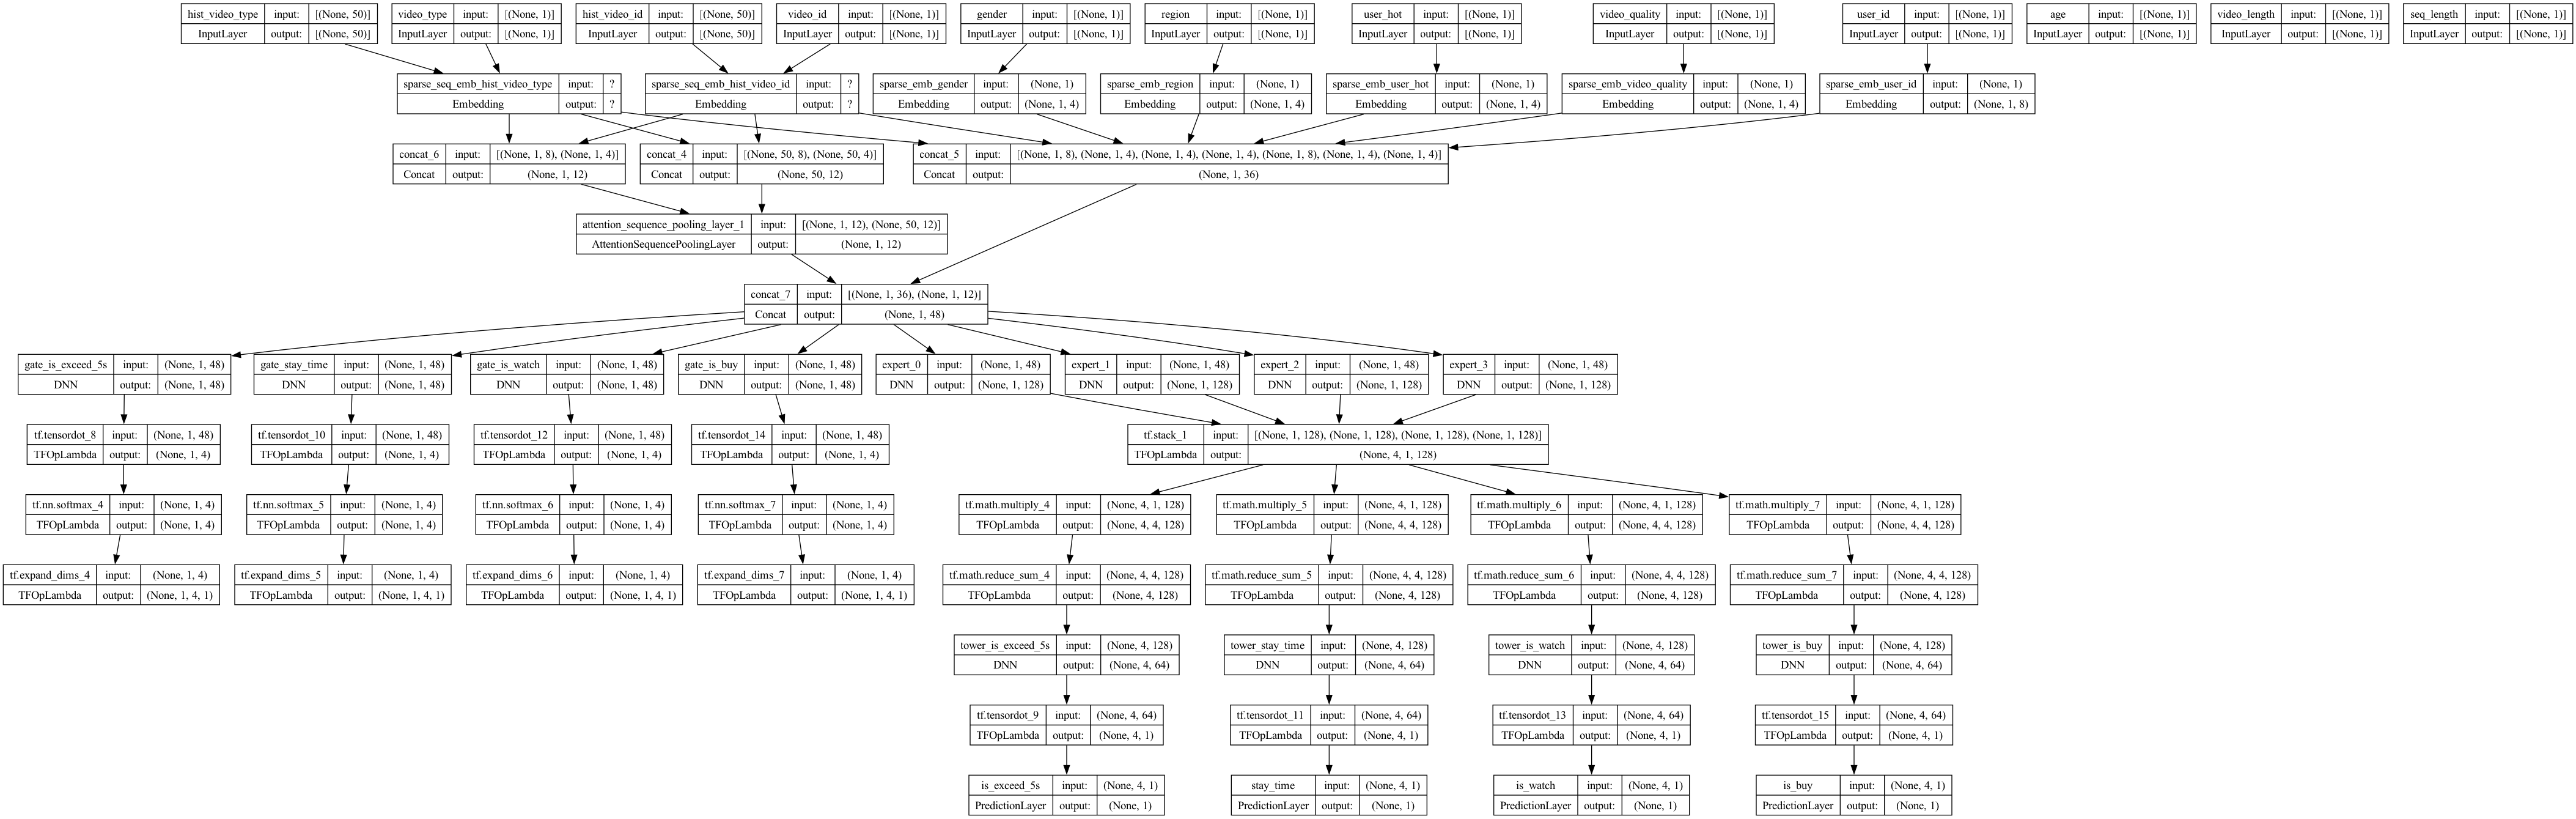

In [12]:
## 查看模型结构
from tensorflow import keras

sparse_features, dense_features, seq_features = get_feature_columns()
dnn_feature_columns = sparse_features + dense_features + seq_features
history_feature_list = ['video_id', 'video_type']

model = DIN_MMOE_2(
    dnn_feature_columns,
    history_feature_list,
    num_experts=4,
    expert_dnn_hidden_units=(256, 128),
    tower_dnn_hidden_units=(64,),
    task_types=('binary', 'regression', 'binary', 'binary'),
    task_names=('is_exceed_5s', 'stay_time', 'is_watch', 'is_buy')
)
keras.utils.plot_model(model, to_file="DIN_MMOE.png", show_shapes=True)

In [ ]:
/opt/homebrew/Cellar/graphviz/12.2.1/bin

export PATH="/opt/homebrew/Cellar/graphviz/12.2.1/bin:$PATH"
